## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [2]:
hr_filenames = glob.glob('/data/crisdb/*.npz')
print('Total file',len(hr_filenames))
ecg = {}
for i, fl in enumerate(hr_filenames):
    # For each file, load the data...
    with np.load(fl) as npz:
        hr = npz['hr']
        base_name = fl.split('/')[-1]
        subject = base_name.split('.')[0]
        ecg[subject] = hr
print(len(ecg.keys()))

Total file 1537
1537


#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [3]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
#with open(metadata_filename, 'r') as f:
#    metadata = metadata = f.read()
metadata = pd.read_csv(metadata_filename)
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


In [4]:
metadata.describe()

,subject,age,sex
count,1543,1543,1543
unique,1543,11,2
top,e202b,60-64,Male
freq,1,313,1266


In [5]:
metadata.shape

(1543, 3)

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [6]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    base_name = filename.split('/')[-1]
    subject = base_name.split('.')[0]
    
    row = metadata[metadata['subject'] == subject]
    # Find the age group for this subject in metadata.
    age_group = row['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = row['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [7]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


In [11]:
df.describe(include='all')

,age_group,sex,rhr,xaxis
count,1537,1537,1537.000000,1537.000000
unique,9,2,NaN,NaN
top,60-64,Male,NaN,NaN
freq,313,1260,NaN,NaN
mean,NaN,NaN,63.547747,4.757970
std,NaN,NaN,13.357361,1.908036
min,NaN,NaN,1.558870,0.000000
25%,NaN,NaN,54.468085,4.000000
50%,NaN,NaN,62.439024,5.000000
75%,NaN,NaN,71.111111,6.000000


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

In [8]:
#!pip install seaborn==0.9.0

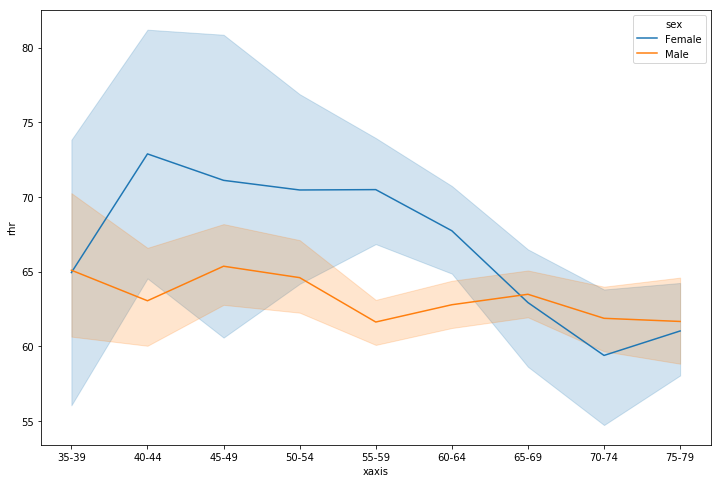

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)
plt.show()

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Your write-up will go here...
> 1. For women, we see the confident interval of the age 35-59 is high. Mean women heart rate is greater variability.
> 2. For men, we see more consistent heart rate from the age 35-79.
> 3. In comparison to men, women's heart rate is higher for the age 35-65, but lower for the age 65-79. Both man and women has smallest confident interval in the age 55-64
> 4. The data is imbalance between men and women. Number of men is 4 times higher than number of women. The data is imbalance between the age groups also. Almost data is in age range 55-74
> 5. We can try with higher percentile value to see what is the output. We can get more women data, and get more data in the age 35-55 to improve the results
> 6. With this data we could not validate that average resting heart rate increases up until middle age and then decreases into old age. The chart show that women heart rate is increases in age group 40-45, but the sample is very small and confident interval is high. The trend of man heart rate decreases from 35-79.  

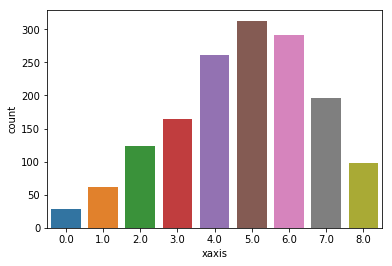

In [19]:
ax = sns.countplot(x='xaxis', data=df)

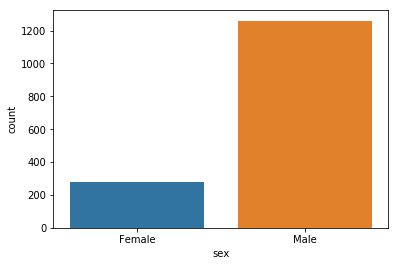

In [20]:
ax = sns.countplot(x="sex", data=df)

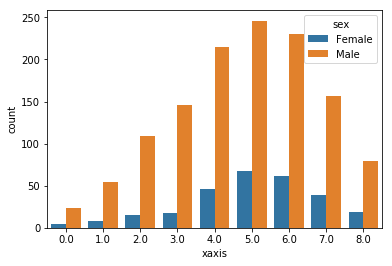

In [21]:
ax = sns.countplot(x="xaxis", hue="sex", data=df)